# TP1: Conversion of Sampling Frequency and STFT

*By Daniel Jorge Deutsch, Kevin Kuhl and Santiago Velandia (25/09/2020)*

</br>

## Code Setup

### Windows

1. Make sure you have python >=3.6 installed
2. Create a virtual environment and activate it
    2.1 pip install virtualenv
    2.2 virtualenv venv 
    2.3 .\venv\scripts\activate.bat
3. Install the dependencies of the code listed in the file requirements.txt
    3.1 pip install -r requirements.txt
4. Create the input folder manually and place there the file named "caravan_48khz.wav":
    4.1 ./inputs/caravan_48khz.wav
5. Create the output folders manually:
    5.1 ./outputs/figures
    5.2 ./outputs/sounds
6. Enjoy the code :)

Obs: if pyaudio doesn't work at first you might have to do the following:

1. pip install pipwin
2. pipwin install pyaudio

\begin{align}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{align}

In [149]:
import os
import struct
import sys
import wave
from copy import deepcopy
from math import ceil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyaudio
from scipy import signal as sig
from scipy.io import wavfile

In [158]:
class Signal:

    def __init__(self, name, signal=None, rate=None, file=None):

        if not (file or not signal is None):
            raise Exception("You must at least pass a signal or a .wav file")
        if file and not signal is None:
            raise Exception("You can only pass a signal or a .wav file (not both)")

        self.name = name 

        if not signal is None:
            self.signal = np.asarray(signal)
            if not rate:
                raise Exception("Since you provided the signal you should pass its rate")
            self.rate = int(rate)
        if file:
            self.file = file
            self.rate, self.signal = wavfile.read(self.file)
            self.rate = int(self.rate)
            self.signal = np.asarray(self.signal)
            
    
    #------------------------------#
    #--- OPERATIONS ---------------#
    #------------------------------#

    def convolve(self, name, signal):
        if not (self.rate or signal.rate):
            raise Exception("the sample rate (sample/sec) must be provided")
        rate = signal.rate if signal.rate else self.rate
        return self.__class__(name, signal=np.convolve(self.signal, signal.signal), rate=rate)


    #------------------------------#
    #--- SAMPLING -----------------#
    #------------------------------#

    def remove_samples(self, name, M):
        if not isinstance(M, int):
            raise Exception("M must be an integer")
        res = self.signal[::M]
        return self.__class__(name=name, signal=res, rate=self.rate/M)


    def insert_zeros(self, name, L):
        if not isinstance(L, int):
            raise Exception("L must be an integer")
        res = np.insert(self.signal, range(1, len(self.signal)+1)[::L-1], 0)
        return self.__class__(name=name, signal=res, rate=self.rate*L)


    #------------------------------#
    #--- PLOTS --------------------#
    #------------------------------#

    def time_plot(self, rate=None, figsize=(30, 4), save=False):
        if not (self.rate or rate):
            raise Exception("the sample rate (sample/sec) must be provided")
        rate = rate if rate else self.rate
        xaxis = np.arange(len(self.signal))/rate
        plt.figure(figsize=figsize)
        plt.fill_between(xaxis, self.signal)
        plt.xlim(xaxis[0], xaxis[-1])
        plt.title(f"Time plot of {self.name}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_time.png", dpi=300, bbox_inches="tight")
        plt.show()

    
    def filter_response_plot(self, figsize=(15, 4), save=False):
        
        xaxis, yaxis = sig.freqz(self.signal)   
        xaxis = xaxis/(2*np.pi)                 # Frequency of the signal in (rad/sample)/2π
        yaxis = 10*np.log10(abs(yaxis))         # Magnitude of the signal
        plt.figure(figsize=figsize)
        plt.title(f"Frequency response of {self.name}")
        plt.xlabel("Frequency ((rad/sample)/2π)")
        plt.ylabel(f"Magnitude of {self.name} (dB)")
        plt.plot(xaxis, yaxis)
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_freq_res.png", dpi=300, bbox_inches="tight")
        plt.show()


    def fft_plot(self, figsize=(15, 4), save=False, window=False):
        fft_size = 4096
        
        A = np.fft.fft(self.signal,fft_size)

        mag = np.abs(np.fft.fftshift(A))

        freq = np.linspace(-0.5, 0.5, len(A))

        with np.errstate(divide='ignore', invalid='ignore'):
            response = 20 * np.log10(mag)

        response = np.clip(response, -150, 150)

        plt.figure(figsize=figsize)
        
        plt.plot(freq, response)

        plt.title("Frequency response of {}".format(self.name))

        plt.ylabel("Magnitude [dB]")

        plt.xlabel("Normalized frequency [cycles per sample]")
        if window:
            plt.title("Frequency response of {} (main lobe width: {})".format(self.name,4/len(w.signal)))
            plt.axvline(x=-2/len(w.signal), color="red")
            plt.axvline(x=2/len(w.signal), color="red")
        
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_fft.png", dpi=300, bbox_inches="tight")
        
        plt.show()


    
    #------------------------------#
    #--- LISTEN -------------------#
    #------------------------------#
    
    def listen(self, rate=None, chunk=1024):
        
        # Saves the .wav
        if not (self.rate or rate):
            raise Exception("the sample rate (sample/sec) must be provided")
        rate = rate if rate else self.rate
        wavfile.write(f"./outputs/sounds/{self.name}.wav", rate, np.asarray(self.signal, dtype=np.int16))

        # Uses pyaudio to play the signal
        pa = pyaudio.PyAudio()
        audio = wave.open(f"./outputs/sounds/{self.name}.wav", "rb")
        stream = pa.open(
            format = pa.get_format_from_width(audio.getsampwidth()),
            channels = audio.getnchannels(),
            rate = audio.getframerate(),
            output = True
        )
        data = audio.readframes(chunk)
        while data:
            stream.write(data)
            data = audio.readframes(chunk)
        stream.stop_stream()
        stream.close()
        pa.terminate()

In [159]:
class Filter:

    def __init__(self):
        pass

    

In [160]:
# Obtains the input signal x from its file
x = Signal(name="x", file="./inputs/caravan_48khz.wav")

# Defines the over and under sampling constants
L = 2
M = 3

# Obtains the over sampled signal w using L=2 (Fw=48*2=96kHz)
w = x.insert_zeros("w", L)

# Defines the Remez filter params
numtaps = 100                       # An even number (can't be too big)
trans_width = 1/13                  # ?
cutoff = min( 1/(2*L), 1/(2*M) )    # Cutoff frequency (should be 1/(2*M) = 1/6)

# Obtains the Remez filter
h = Signal(name="h", signal=sig.remez(numtaps, [0, cutoff, cutoff+trans_width, 1/2], [L, 0]), rate=w.rate)

# Calculates the convolution v=w*h
v = w.convolve(name="v", signal=h)

# Undersample the convolution result to obtain the output of the system using M=3 (Fy=96/3=32kHz)
y = v.remove_samples("y", M)

# Polyphase

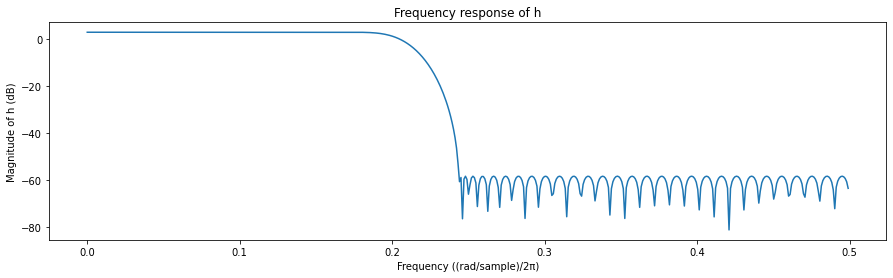

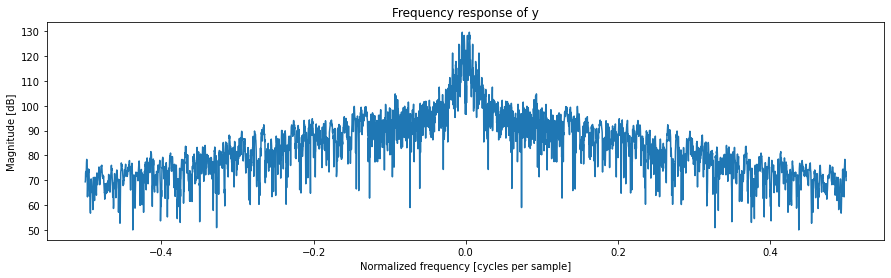

In [161]:
h0 = Signal("h0", h.signal[::2], h.rate/2)
h1 = Signal("h1", h.signal[1::2], h.rate/2)

w0 = x.convolve("w0", h0)
w1 = x.convolve("w1", h1)

v0 = w0.insert_zeros("v0", 2)
v1 = w1.insert_zeros("v1", 2)

v0.signal = np.append([0],v0.signal[:-1])

v = Signal("v", v0.signal+v1.signal, v0.rate)


#------------------------------#
#--- LISTEN -------------------#
#------------------------------#

u0 = Signal("u0", v.signal, v.rate)
u1 = Signal("u1", np.append([0],v.signal[:-1]), v.rate)
u2 = Signal("u2", np.append([0, 0],v.signal[:-2]), v.rate)

a0 = u0.remove_samples("a0", M)
a1 = u1.remove_samples("a1", M)
a2 = u2.remove_samples("a2", M)

h0 = Signal("h0", h.signal[:-1:3], h.rate/2)
h1 = Signal("h1", h.signal[1::3], h.rate/2)
h2 = Signal("h2", h.signal[2::3], h.rate/2)

y0 = a0.convolve("y0", h0)
y1 = a1.convolve("y1", h1)
y2 = a2.convolve("y2", h2)

y = Signal("y", y0.signal+y1.signal+y2.signal, a0.rate)
h.filter_response_plot()
y.fft_plot()

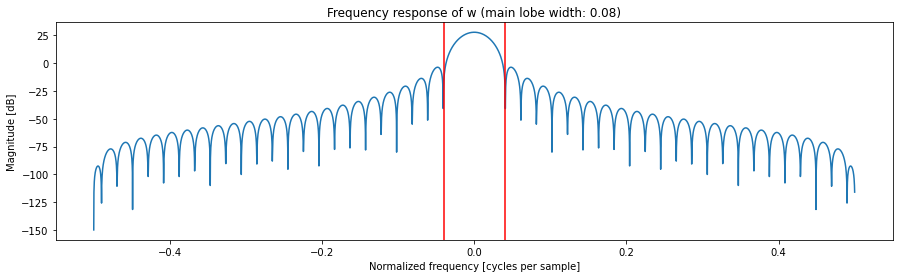

In [162]:
N = x.signal.shape[0] # % longueur du signal
Nw = 50
w = np.hanning(Nw)  # définition de la fenetre d'analyse
ws = w.copy   # définition de la fenêtre de synthèse
R = Nw/4 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 512 # ordre de la tfd
L = M/2+1
affich = 1   # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

w = Signal("w", w, rate=32000)
w.fft_plot(window=True)